In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!git clone https://github.com/TiwariShivam333/Material-Recognition

Cloning into 'Material-Recognition'...
remote: Enumerating objects: 412, done.
remote: Total 412 (delta 0), reused 0 (delta 0), pack-reused 412
Receiving objects: 100% (412/412), 14.07 MiB | 43.39 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [0]:
import numpy as np
import pandas as pd
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, Callback
from google.colab.patches import cv2_imshow
import h5py
import cv2
import os
from tqdm import tqdm
from random import shuffle

In [0]:
classes = 4
img_height = 150
img_width = 150
epochs_all_layers = 100
batch_size = 32

In [0]:
file_paths = ["Material-Recognition/metal/","Material-Recognition/leather/","Material-Recognition/wood/","Material-Recognition/glass/"]
training_data = []
label = -1
for file_path in file_paths:
  label = label + 1
  for img in tqdm(os.listdir(file_path)):
    path = os.path.join(file_path,img)
    image = cv2.imread(path)
    image = cv2.resize(image, (img_height, img_width))
    training_data.append([np.array(image),np.array(label)])

100%|██████████| 100/100 [00:00<00:00, 447.21it/s]


In [0]:
dataset = training_data
dataset = np.array(dataset)
features = dataset[:, 0]
labels = dataset[:, 1]
labels_one_hot_encoded = to_categorical(labels, classes)

In [0]:
feature =[]
for i in range(len(features)):
    feature.append(features[i])

features = np.asarray(feature)
x_train, x_test, y_train, y_test= train_test_split(features, labels_one_hot_encoded, test_size = 0.30, stratify = labels_one_hot_encoded)

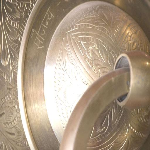

[1. 0. 0. 0.]


In [0]:
cv2_imshow(x_train[100])
print(y_train[100])

In [0]:
base_model = InceptionV3(include_top = False,weights = 'imagenet',input_shape=(img_height,img_width,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(classes, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_565 (Conv2D)             (None, 74, 74, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_565 (BatchN (None, 74, 74, 32)   96          conv2d_565[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, 74, 74, 32)   0           batch_normalization_565[0][0]    
__________________________________________________________________________________________________
conv2d_566

In [0]:
train_datagen = ImageDataGenerator(rotation_range=10,shear_range= 10,zoom_range = 0.1,fill_mode ='reflect',horizontal_flip = True)

In [0]:
train_generator = train_datagen.flow(x_train,y_train,batch_size  = batch_size)

In [0]:
for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [0]:
%%time
model.fit_generator(generator = train_generator,steps_per_epoch = len(x_train) // 32,epochs = 25,
    validation_data =(x_test, y_test))

Epoch 1/25
8/8 [==============================] - 2s 200ms/step - loss: 0.1630 - acc: 0.9624 - val_loss: 3.4927 - val_acc: 0.4750
Epoch 2/25
8/8 [==============================] - 2s 189ms/step - loss: 0.1275 - acc: 0.9686 - val_loss: 2.8879 - val_acc: 0.5000
Epoch 3/25
8/8 [==============================] - 2s 197ms/step - loss: 0.1136 - acc: 0.9647 - val_loss: 3.0730 - val_acc: 0.5083
Epoch 4/25
8/8 [==============================] - 2s 200ms/step - loss: 0.0828 - acc: 0.9714 - val_loss: 3.5393 - val_acc: 0.5250
Epoch 5/25
8/8 [==============================] - 2s 210ms/step - loss: 0.1414 - acc: 0.9688 - val_loss: 2.9169 - val_acc: 0.5000
Epoch 6/25
8/8 [==============================] - 2s 198ms/step - loss: 0.1355 - acc: 0.9479 - val_loss: 3.4746 - val_acc: 0.5000
Epoch 7/25
8/8 [==============================] - 2s 202ms/step - loss: 0.0798 - acc: 0.9742 - val_loss: 4.0811 - val_acc: 0.4583
Epoch 8/25
8/8 [==============================] - 2s 201ms/step - loss: 0.1382 - acc: 0.95

In [0]:
model_json = model.to_json()
with open("material_recognition.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("material_recognition.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
y_pred = model.predict(x_test)

In [3]:
from keras.models import model_from_json
json_file = open("gdrive/My Drive/material_recognition0.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("gdrive/My Drive/material_recognition0.h5")
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


In [0]:
classes1 = ['metal','leather','wood','glass']
loaded_model.compile(optimizer   = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

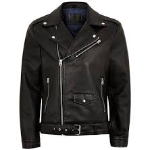

In [10]:
image = cv2.imread("6.jpeg")#("Material-Recognition/wood/wood_moderate_046_new.jpg")
image = cv2.resize(image, (img_height, img_width)) 
cv2_imshow(image)

In [11]:
%%time
result = (loaded_model.predict(np.array([image])))

CPU times: user 2.84 s, sys: 1.04 s, total: 3.89 s
Wall time: 5.44 s


In [12]:
print(classes1[result[0].argmax()])

leather
